# Loading Modules

In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_recall_curve
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

In [2]:
def prob_adjusted_outcome(model_probabilities,threshold):
    y_adjusted=[]
    for prob in model_probabilities:
        if prob[1] > threshold:
            y_adjusted.append(True)
        else:
            y_adjusted.append(False)
    return y_adjusted

# Loading Dataset and Reordering Data

In [3]:
filename='ATA_data.csv'

df = pd.read_csv(filename)
df=df.drop('Unnamed: 0',1)

df.columns.unique()

cats_to_keep=['entertainment', 'games', 'lifestyle', 'music', 'photography', 'productivity', 
             'social_networking', 'sports', 'travel', 'utilities']

df=df[df.app_type.isin(cats_to_keep)]

#### Taking interesting features

In [10]:
cols_to_keep=['installed','clicked','impression','app_type','weekday','hours']
filtered_df=df[cols_to_keep]

### Downsampling, remove the majority class by user set percentage

In [11]:
False_df=filtered_df[filtered_df['installed'] == False]
Truth_df=filtered_df[filtered_df['installed'] == True]

target_downsampling = 0.50;
downsampling=int(np.round((Truth_df.shape[0]/target_downsampling)*(1-target_downsampling)))

#Downsampling by target downsample rate
Downsampled_False=resample(False_df, n_samples=downsampling, random_state=0, replace = False)

# Merge the downsampled False with total True outcomes
less_imbalance=pd.concat([Downsampled_False,Truth_df])

In [12]:
#No downsampling dataset
clean_data=filtered_df

## Creating the dummy variables.

### Quick dirty comparison of AUC of ROC 

<p> Comparing the ROC_AUC of the complete dataset vs. downsampled dataset. This is used as an indication of model stability. </p>

<p> 

Use patsy to create the dummy variable

In [13]:
y_com,X_com = dmatrices('installed ~ hours + C(weekday) + C(app_type)'
               ,clean_data, return_type='dataframe'
               )

In [14]:
y_com=np.ravel(y_com.iloc[:,1:])

In [15]:
y_com

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [16]:
roc_auc_com= cross_val_score(LogisticRegression(class_weight='auto', fit_intercept=False),
                          X_com, y_com, scoring='roc_auc', cv =5)

In [17]:
y,X = dmatrices('installed ~ hours + C(weekday) + C(app_type)'
               ,less_imbalance, return_type='dataframe'
               )

In [18]:
y=np.ravel(y.iloc[:,1:])

In [19]:
roc_auc_dsampled= cross_val_score(LogisticRegression(class_weight='auto', fit_intercept=False),
                          X, y, scoring='roc_auc', cv =5)

In [20]:
roc_auc_diff= np.mean(roc_auc_com - roc_auc_dsampled)
print roc_auc_diff

0.00908811560613


## Running different models.

In [21]:
rm=[LogisticRegression(fit_intercept=False), RandomForestClassifier(), LinearSVC(), GradientBoostingClassifier(max_depth=3)]
cvs=5
model_aucs=np.empty((len(rm),cvs))
model_recalls=np.empty((len(rm),cvs))
model_precision=np.empty((len(rm),cvs))

for i,models in enumerate(rm):
    
    model_recalls[i,:] = cross_val_score(models, X, y, scoring = 'recall', cv = cvs)
    model_precision[i,:] = cross_val_score(models, X, y, scoring = 'precision', cv = cvs)
    model_aucs[i,:] = cross_val_score(models, X, y, scoring = 'roc_auc', cv = cvs)


In [22]:
summary_matrices = np.empty((6,len(rm)))
summary_matrices[0, :] = np.mean(model_recalls, axis=1)
summary_matrices[1, :] = np.std(model_recalls, axis = 1)
summary_matrices[2, :] = np.mean(model_precision, axis=1)
summary_matrices[3, :] = np.std(model_precision, axis = 1)
summary_matrices[4, :] = np.mean(model_aucs, axis=1)
summary_matrices[5, :] = np.std(model_aucs, axis = 1)

In [23]:
summary_df=pd.DataFrame(summary_matrices)
summary_df.columns=['Logistic Regression', 'Random Forest', 'Linear SVC', 'GradientBoostClassifier']
summary_df.index=['Recall mean', 'Recall std', 'Precision mean', 'Precision std', 'ROC_AUC mean', 'ROC_AUC std']

In [24]:
summary_df

,Logistic Regression,Random Forest,Linear SVC,GradientBoostClassifier
Recall mean,0.718492,0.549929,0.674344,0.648530
Recall std,0.132833,0.045149,0.247177,0.059857
Precision mean,0.537776,0.537999,0.536772,0.551129
Precision std,0.031245,0.025087,0.023670,0.023980
ROC_AUC mean,0.559329,0.557823,0.559536,0.566973
ROC_AUC std,0.036102,0.026982,0.036896,0.028127


#### Using 90% of data to train.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Logistic Regression 

In [26]:
modelLogR2 = LogisticRegression(class_weight='auto',fit_intercept=False);
modelLogR2.fit(X_train, y_train);

In [27]:
pd.DataFrame(zip(X_train.columns, np.transpose(modelLogR2.coef_)))

,0,1
0,Intercept,[-0.851950810167]
1,C(weekday)[T.2],[-0.176030310536]
2,C(weekday)[T.3],[-0.510803962895]
3,C(weekday)[T.4],[-0.386893082976]
4,C(weekday)[T.5],[-0.147138848654]
5,C(weekday)[T.6],[-0.0718215309963]
6,C(weekday)[T.7],[0.0805888986078]
7,C(app_type)[T.games],[1.03653054784]
8,C(app_type)[T.lifestyle],[0.0977922083821]
9,C(app_type)[T.music],[-0.471685922659]


In [28]:
#Use Training Set to verify if model is learning anything
verify_train = modelLogR2.predict(X_train)
prob_train = modelLogR2.predict_proba(X_train)
recall_score(y_train,verify_train)




0.79076479076479078

In [29]:
#metrics for recall and confusion matrix

print confusion_matrix(y_train, verify_train, labels=[True, False]).transpose()
print classification_report(y_train, verify_train)

[[548 425]
 [145 269]]
             precision    recall  f1-score   support

        0.0       0.65      0.39      0.49       694
        1.0       0.56      0.79      0.66       693

avg / total       0.61      0.59      0.57      1387



In [30]:
#Prediction using test set
predictedLR2 = modelLogR2.predict(X_test)
probLR2 = modelLogR2.predict_proba(X_test)
recall_score(y_test,predictedLR2)




0.80769230769230771

In [31]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_test, predictedLR2, labels=[True, False]).transpose()
print cm
print classification_report(y_test, predictedLR2)

[[63 43]
 [15 34]]
             precision    recall  f1-score   support

        0.0       0.69      0.44      0.54        77
        1.0       0.59      0.81      0.68        78

avg / total       0.64      0.63      0.61       155



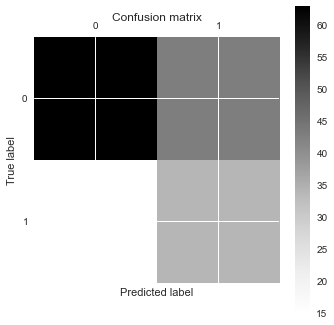

In [32]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label');
plt.xlabel('Predicted label');

In [41]:
filename='ATA2_data.csv'

df2 = pd.read_csv(filename)
df2=df2.drop('Unnamed: 0',1)

df2.columns.unique()

cats_to_keep=['entertainment', 'games', 'lifestyle', 'music', 'photography', 'productivity', 
             'social_networking', 'sports', 'travel', 'utilities']

df2=df2[df2.app_type.isin(cats_to_keep)]

In [57]:
cols_to_keep=['installed','clicked','impression','app_type','weekday','hours', 'week']
filtered_df2=df2[cols_to_keep]

In [58]:
np.mean(filtered_df2['installed'])

0.00047496573285487671

In [59]:
y_val,X_val = dmatrices('installed ~ hours + C(weekday) + C(app_type)'
               ,df2, return_type='dataframe'
               )

In [60]:
y_val=np.ravel(y_val.iloc[:,1:])

In [61]:
#Validate using validation set
predictedVal = modelLogR2.predict(X_val)
probVal = modelLogR2.predict_proba(X_val)
recall_score(y_val,predictedVal)




0.79247730220492862

In [62]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_val, predictedVal, labels=[True, False]).transpose()
print cm
print classification_report(y_val, predictedVal)

[[   611 985328]
 [   160 637176]]
             precision    recall  f1-score   support

        0.0       1.00      0.39      0.56   1622504
        1.0       0.00      0.79      0.00       771

avg / total       1.00      0.39      0.56   1623275



In [63]:
y_probVal=prob_class_outcome(probVal,1)

(array([  49079.,  100959.,   81303.,   37176.,   57769.,    9825.,
         147841.,  180419.,  519684.,  439220.]),
 array([ 0.1004191 ,  0.15149017,  0.20256124,  0.25363231,  0.30470338,
         0.35577446,  0.40684553,  0.4579166 ,  0.50898767,  0.56005874,
         0.61112981]),
 <a list of 10 Patch objects>)

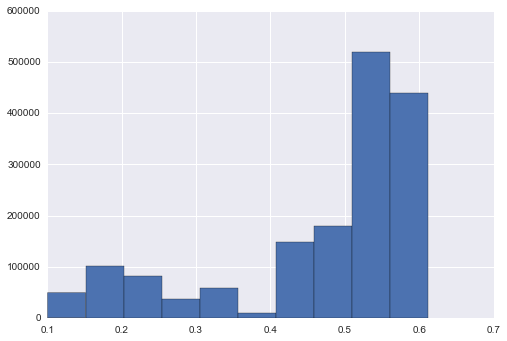

In [106]:
plt.hist(y_probVal)

In [95]:
Validation_prob=pd.DataFrame(df2['installed'])

In [96]:
Validation_prob['week']=df2['week']

In [100]:
Validation_prob['Prob']=y_probVal

In [107]:
lessThan20Per=Validation_prob[Validation_prob['Prob'] < 0.20]

In [109]:
lessThan20Per.shape

(146242, 3)

In [120]:
drop_index=Validation_prob[np.logical_and(Validation_prob['Prob'] <0.30 , Validation_prob['installed'])]

In [122]:
drop_index.shape

(27, 3)

In [102]:
Validation_prob.groupby('week').sum()

,installed,Prob
week,,
20,93,127872.112975
21,149,163033.994780
22,202,154028.667784
23,92,71737.354805
24,64,40707.759880
25,43,43466.726631
26,24,34388.787930
27,28,35637.473570
28,42,36291.220270


In [91]:
def TrueFalse(value):
    if value[0]=='F':
        value = False
    else:
        value = True
    return value

In [88]:
df2.dtypes

datetime                object
advertiser_bundle_id     int64
creative_id              int64
ad_id                    int64
app_id                   int64
bidadop_id               int64
app_name                object
app_categories          object
publisher_name          object
device_idfa             object
os                      object
osv                     object
make                    object
model                   object
country                 object
city                    object
language                object
impression                bool
clicked                   bool
installed                 bool
app_type                object
weekday                  int64
hours                    int64
week                     int64
dtype: object

In [90]:
Validation_prob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1623275 entries, 0 to 1623274
Data columns (total 3 columns):
Prob         1623275 non-null float64
week         1609791 non-null float64
installed    1609791 non-null object
dtypes: float64(2), object(1)
memory usage: 49.5+ MB


In [82]:
Validation_prob.groupby('week')['Prob','installed'].sum()

,Prob
week,
20,128186.767147
21,163958.578731
22,154025.060026
23,72136.865192
24,40847.736876
25,42735.788719
26,34586.903330
27,35319.990439
28,36208.114470


In [103]:
Val_df=Validation_prob[Validation_prob['installed'] == True]

In [105]:
Val_df.shape

(771, 3)

In [56]:
np.sum(np.array(y_probVal))/np.sum(y_val)

989.53940441427335

In [33]:
y_adjusted=prob_adjusted_outcome(probLR2,0.5)

In [34]:
print classification_report(y_test, y_adjusted)

             precision    recall  f1-score   support

        0.0       0.69      0.44      0.54        77
        1.0       0.59      0.81      0.68        78

avg / total       0.64      0.63      0.61       155



In [49]:
def prob_class_outcome(model_probabilities,select_class):
    prob_class=[]
    for prob in model_probabilities:
            prob_class.append(prob[select_class])
    return prob_class

In [36]:
y_prob=prob_class_outcome(probLR2,1)

In [37]:
np.sum(np.array(y_prob))/np.sum(y_test)

0.97247602983348624

In [38]:
np.sum(y_test)

78.0

In [39]:

# Precision Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test,y_prob)

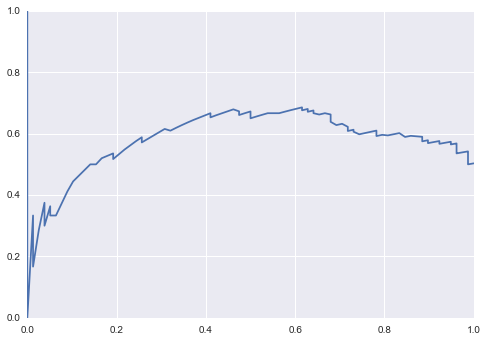

In [40]:
plt.plot(recall,precision)

### Gradient Boosting Classifier

In [ ]:
modelGBC = GradientBoostingClassifier();
modelGBC.fit(X_train, y_train);

In [ ]:
pd.DataFrame(zip(X_train.columns, np.transpose(modelGBC.feature_importances_)))

In [ ]:
#Use Training Set to verify if model is learning anything
verify_train = modelGBC.predict(X_train)
prob_train = modelGBC.predict_proba(X_train)
recall_score(y_train,verify_train)

In [ ]:
#metrics for recall and confusion matrix

print confusion_matrix(y_train, verify_train, labels=[True, False]).transpose()
print classification_report(y_train, verify_train)

In [ ]:
#Prediction using test set
predictedGBC = modelGBC.predict(X_test)
probGBC = modelGBC.predict_proba(X_test)
recall_score(y_test,predictedGBC)

In [ ]:
#metrics for recall and confusion matrix

cm = confusion_matrix(y_test, predictedGBC, labels=[True, False]).transpose()
print cm
print classification_report(y_test, predictedGBC)

In [ ]:
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label');
plt.xlabel('Predicted label');

In [ ]:
np.mean(y_test)

#### Rank Users based on predicted probabilities

In [ ]:
ranked_df=pd.DataFrame(predictedGBC)
ranked_df['Probabilities'] = prob_class_outcome(probGBC,1)
ranked_df.columns=['Predicted Outcomes','Probabilities']
ranked_df.sort(columns='Probabilities')

In [ ]:
rank_percentile = np.percentile(ranked_df['Probabilities'],1)

In [ ]:
plt.hist(ranked_df['Probabilities'])

In [ ]:
rank_percentile

### Random Forests

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
modelRandomForest= RandomForestClassifier(class_weight='auto', n_estimators=100)
modelRandomForest.fit(X_train, y_train)

In [ ]:
# Random Forest Predictions
predictedRF = modelRandomForest.predict(X_train)
probs = modelRandomForest.predict_proba(X_train)

In [ ]:
# Look at precision/recall and confusion matrix

print confusion_matrix(y_train,predictedRF)
print classification_report(y_train,predictedRF)

In [ ]:
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [ ]:
grid_search = GridSearchCV(modelRandomForest, param_grid=param_grid)

In [ ]:
for params, mean_score, scores in ZZ.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() * 2, params))

In [ ]:
ZZ=grid_search.fit(X_train,y_train)

In [ ]:
ZZ.best_params_

In [ ]:
XX=ZZ.predict(X_test)

In [ ]:
print confusion_matrix(y_test,XX)
print classification_report(y_test,XX)